# Image restauration

Images restauration is the idea of recovery and **original** image from a **degradated** image knowing before hand the process of degradation. The recovered image is called **restaurated**.

Let $F$ a matrix that represent the original photo (with $f$ a line, array, of the image), $G$ the degradated image (with $g$ a line) and $\hat F$ the restaurated image. The degradation process is an uniform horizontal movement.

$$
g_i = (f_i + f_{i + 1} + ... + f_{i + n - 1})/n
$$

Let $H$ a matrix that represent the movement so $g = Hf$.

$$
g = H*f = \begin{bmatrix}
h_1 & \dots & h_n & 0 & 0 & 0 &  0 \\
0 & h_1 & \dots & h_n  & 0 & 0 & 0 \\
& & \vdots   & &   \vdots \\
0 & 0 & \dots & h_1 & \dots & h_n 
\end{bmatrix} 
\begin{bmatrix}
f_1 \\
f_2 \\
\vdots \\
f_n
\end{bmatrix} =
\begin{bmatrix}
g_1 \\
g_2 \\
\vdots \\
g_n
\end{bmatrix} 
$$

So, if $M$ is the number of colllums of $F$ and $n$ is the displacement, then the number of collums $N$ of $G$ is $N = M - n + 1$

## Libraries

In [1]:
from IPython.display import display
import numpy as np
from PIL import Image

In [40]:
def show_img(img_array):
    img = Image.fromarray(img_array, 'L')
    display(img)

def fix_array(arr):
    arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr)) * 255
    arr = arr.astype('uint8')
    return arr

## Create $G$

### Get the original image

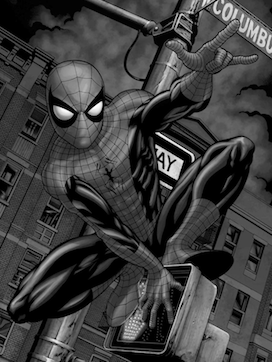

[[  0   0   0 ...  37  38  34]
 [  0   0   0 ...  37  37  36]
 [  0   0   0 ...  37  37  36]
 ...
 [104  96  94 ...  58  55  54]
 [113 112 109 ...  55  44  59]
 [112 121 123 ...  58  58  55]] (362, 272)


In [57]:
img = Image.open('./img/spiderman.png').convert('L')
display(img)

F = np.asarray(img)
print(F, F.shape)

### Create the model

In [238]:
n = 10
H = []

M = len(F[0])
N = M - n +1
print(f"M = {M} N = {N}")
for i in range(N):
    row = [0] * M 
    
    for j in range(i, i + n):
        if (j < M): row[j] = 1/n
        
    H.append(row)
    
H = np.matrix(H)
print(H, H.shape)

M = 272 N = 263
[[0.1 0.1 0.1 ... 0.  0.  0. ]
 [0.  0.1 0.1 ... 0.  0.  0. ]
 [0.  0.  0.1 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.1 0.  0. ]
 [0.  0.  0.  ... 0.1 0.1 0. ]
 [0.  0.  0.  ... 0.1 0.1 0.1]] (263, 272)


### Generate G

[[  2   3   4 ...  44  42  41]
 [  1   2   4 ...  45  43  42]
 [  0   1   2 ...  47  45  43]
 ...
 [ 76  71  68 ...  36  40  46]
 [ 91  83  75 ...  49  51  52]
 [109 101  92 ...  67  68  65]] (362, 263)
M = 272 N = 263


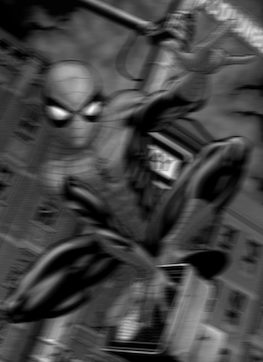

In [239]:
G = (H@F.T).transpose()
G =fix_array(G)

print(G, G.shape)
print(f"M = {M} N = {N}")
show_img(G)

# Recovery $\hat F$

$$
Hf = g \rightarrow f = H^{-1}g 
$$

Problem: there's more unknowns that ecuations. Thus, we have infinity solutions. So, how we chose? let's fix te last collum to have the same amount of ecuation and unknowns. 

[[114 104 115 ... 137 139 138]
 [127  85 119 ... 141 131 132]
 [117  90 120 ... 134 134 136]
 ...
 [172 147 152 ... 143 148 149]
 [179 142 166 ... 142 145 136]
 [172 147 182 ... 134 144 148]] (362, 271)


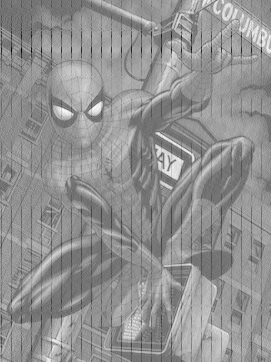

In [172]:
H_ = np.delete(H, M-1, axis=1)
H_inv = np.linalg.pinv(H_)
F_hat = H_inv@G.transpose()

F_hat = fix_array(F_hat).transpose()
print(F_hat, F_hat.shape)
show_img(F_hat)

Know, we want to minimize the distances. The solution $\hat f$ must satisfy:

1. $H\hat f = g$
2. $riz(\hat f) \rightarrow min$


## Lagrange 
$$
\displaylines{
V(f) = \lambda || Hf - g ||^2 + ||f||^2 \rightarrow min \\
\frac{\partial}{\partial f} V(f) = 2\lambda H^T(Hf - g) + 2W^TWf = 0 \\
\hat f = \underbrace{\lambda [\lambda H ^TH+ W^TW]^{-1}H^T}_{A}g = Ag
}
$$

For the whole image 
$$
\hat F = G A^T
$$

[[ 24  34  25 ...  66  64  50]
 [ 44  22  31 ...  50  52  69]
 [ 28  27  32 ...  56  60  66]
 ...
 [121 116  88 ...  79  81  61]
 [129 126 108 ...  73  58  79]
 [118 125 136 ...  73  79  70]] (362, 272)


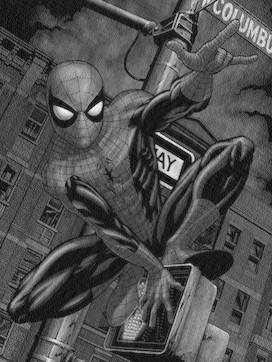

In [241]:
lmbda = 10**6
W = np.eye(M)
A = lmbda * np.linalg.inv(lmbda * np.dot(H.T, H) + np.dot(W.T, W)).dot(H.T)
F_hat = G@A.transpose()

F_hat = fix_array(F_hat)
print(F_hat, F_hat.shape)
show_img(F_hat)

## Newton 
$$
\displaylines{
V(f) = \lambda || Hf - g ||^2 + ||f||^2 \rightarrow min \\
f_{k + 1} = f_k -[\frac{\partial^2}{\partial f^2}  V(f)]^{-1}\frac{\partial}{\partial f}  V(f)' \\ 
\frac{\partial}{\partial f} V(f) = \nabla V(f) = 2\lambda H^T(Hf - g) + 2W^TWf \\
\frac{\partial^2}{\partial f^2} V(f) = \nabla^2 V(f_k) p_k = -\nabla V(f_k) = 2\lambda H^TH + 2W^TW
} 
$$

break at 2
[[ 24  34  25 ...  66  64  50]
 [ 44  22  31 ...  50  52  69]
 [ 28  27  32 ...  56  60  66]
 ...
 [121 116  88 ...  79  81  61]
 [129 126 108 ...  73  58  79]
 [118 125 136 ...  73  79  70]] (362, 272)


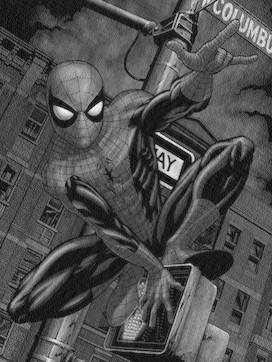

In [245]:
lmbda = 10**6
tol = 10**(-4)
max_iter = 10**6

W = np.eye(M)
F_hat = np.zeros((G.shape[0], H.shape[1]))

for i in range(max_iter):
    gradient = 2 * lmbda * H.T @ (H @ F_hat.T - G.T) + 2* (W.T @ (W @ F_hat.T))
    hessian = 2*lmbda * np.dot(H.T, H) + 2*np.dot(W.T, W)
    F_hat = F_hat + np.dot(np.linalg.inv(hessian),-gradient).T
    if np.linalg.norm(gradient) < tol:
        break
print(f"break at {i}")
F_hat = fix_array(F_hat)
print(F_hat, F_hat.shape)
show_img(F_hat)

## Gradient Descent


## Closed form